# Recurrent neural network model for text generation

This notebook is based upon the previous ones, "Sequential base model for text generation" and "Bag of words base model for text generation", and will skip some exploration and analysis.

## Load data

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dmitry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 393579/393579 [00:02<00:00, 192692.55it/s]


Fitting...
Predicting...


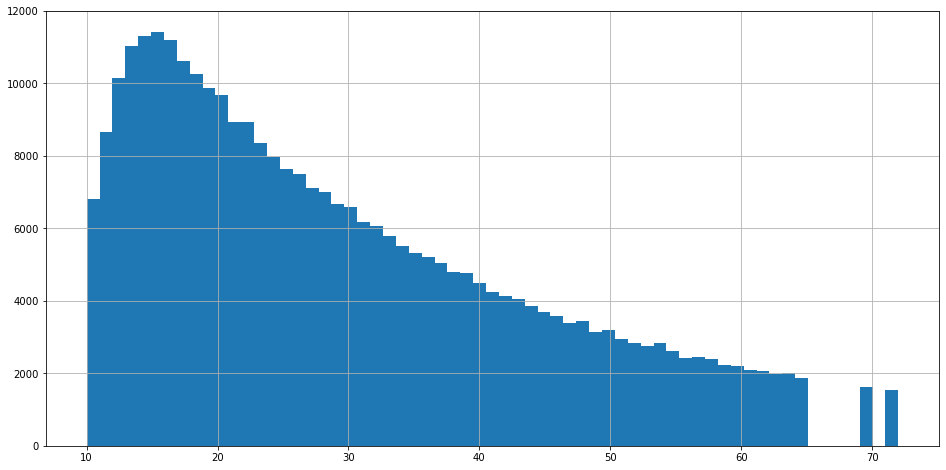

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from tqdm import tqdm
from src.text_preprocessor import TextPreprocessor

tqdm.pandas()

reviews_df = pd.read_csv('../amazon-food-reviews.csv')
reviews_df.columns = [col_name.lower() for col_name in reviews_df.columns]
reviews_df = reviews_df[['text']]
reviews_df = reviews_df.drop_duplicates(subset=['text'])
reviews_df = reviews_df.dropna()

text_preprocessor = TextPreprocessor(lemmatization=False)

reviews_df['text'] = reviews_df['text'].progress_apply(text_preprocessor.process)
reviews_df['wc'] = reviews_df['text'].progress_apply(lambda x: len([word for word in x.split(' ') if word != '']))


from sklearn.ensemble import IsolationForest
wc_isolation_forest = IsolationForest(contamination=0.2)
wc_vector = reviews_df['wc'].to_numpy().reshape((-1, 1))

print('Fitting...')
wc_isolation_forest.fit(wc_vector)

print('Predicting...')
outlier_mask = wc_isolation_forest.predict(wc_vector)
outlier_idx = outlier_mask == -1

filtered_reviews_df = reviews_df[~outlier_idx]

import matplotlib.pyplot as plt
%matplotlib inline

_ = filtered_reviews_df['wc'].hist(bins=63, figsize=(16,8))

## Prepare data for training

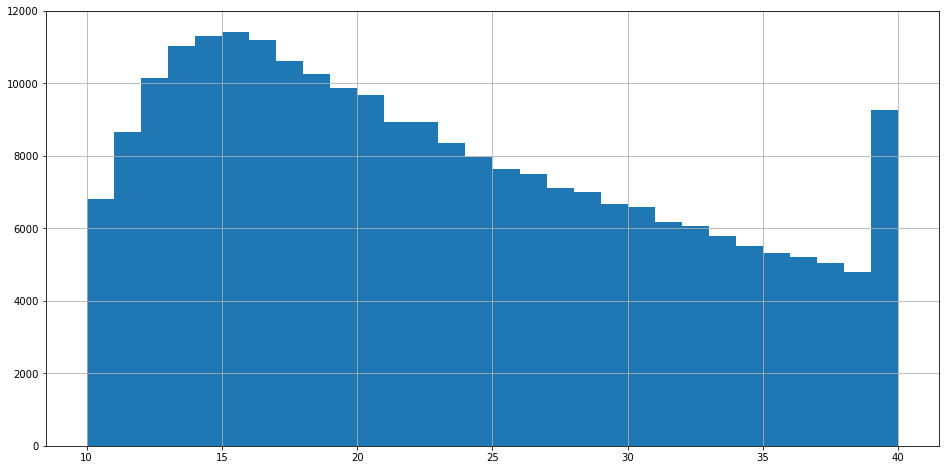

In [2]:
# Debug only!
max_word_count_forced = 41
filtered_reviews_df = filtered_reviews_df[filtered_reviews_df['wc'] < max_word_count_forced]
_ = filtered_reviews_df['wc'].hist(bins=30, figsize=(16,8))

In [3]:
from src.embedding_manager import EmbeddingManager
import numpy as np

em = EmbeddingManager(path='../fasttext.wiki-news-cleaned-290d.vec')

start_token = '<start>'
end_token = '<end>'
pad_token = '<pad>'

# to make preprocessing easier to debug, at first words will be encoded with indicies
input_dict = {word: (i+3) for i, word in enumerate(tqdm(em.embeddings_dict.keys()))}

input_dict[start_token] = 1
input_dict[end_token] = 2
input_dict[pad_token] = 0

reversed_input_dict = {input_dict[key]: key for key in input_dict}

special_vectors = {
    start_token: np.full(em.shape, -2),
    end_token: np.full(em.shape, 2),
    pad_token: np.zeros(em.shape)
}
em.add_special_vectors(special_vectors)

 60%|█████▉    | 366432/611143 [00:00<00:00, 1858418.36it/s]

Total embeddings shape: (611143, 290)


100%|██████████| 611143/611143 [00:00<00:00, 1852041.24it/s]


Total embeddings shape: (611146, 290)


In [4]:
filtered_reviews_df['text'] = filtered_reviews_df['text'].apply(lambda row: f'{start_token} {row} {end_token}')

windowed_data = []
for _, row in tqdm(filtered_reviews_df.sample(n=50000).iterrows()):
    words = row['text'].split()
    for i in range(1, len(words)):
        text = ' '.join(words[:i])
        target_word = words[i]
        windowed_data.append({
            'text': text,
            'target_word': target_word
        })
        
windowed_df = pd.DataFrame(windowed_data)

def get_output(target_word):
    if target_word in text_preprocessor.stopwords:
        return -1
    if target_word not in input_dict:
        return -1
    
    return input_dict[target_word]

windowed_df['output'] = windowed_df['target_word'].progress_apply(get_output)
windowed_df = windowed_df[windowed_df['output'] != -1]

windowed_df['seq'] = windowed_df['text'].progress_apply(lambda row: [input_dict[word] for word in row.split() if word in input_dict])
windowed_df['wc'] = windowed_df['text'].progress_apply(lambda x: len([word for word in x.split() if word is not '']))
windowed_df['seq_len'] = windowed_df['seq'].progress_apply(lambda seq: len(seq))

# check how many entries lost more than 20% of words due to vocabulary limitations:
insufficient_vocabulary_df = windowed_df[(windowed_df['seq_len'] * 1.25 < windowed_df['wc'])]
clean_seq_reviews_df = windowed_df[~windowed_df.index.isin(insufficient_vocabulary_df.index)]
clean_seq_reviews_df.describe()

50000it [00:04, 10233.27it/s]
100%|██████████| 1097301/1097301 [00:01<00:00, 936995.28it/s] 


,output,wc,seq_len
count,1.093692e+06,1.093692e+06,1.093692e+06
mean,9.319883e+03,1.383946e+01,1.373707e+01
std,3.147456e+04,9.142018e+00,9.075547e+00
min,2.000000e+00,1.000000e+00,1.000000e+00
25%,3.650000e+02,6.000000e+00,6.000000e+00
50%,1.868000e+03,1.200000e+01,1.200000e+01
75%,6.671000e+03,2.000000e+01,2.000000e+01
max,6.111140e+05,4.100000e+01,4.100000e+01


### Balancing outputs

100%|██████████| 23843/23843 [00:17<00:00, 1393.32it/s]


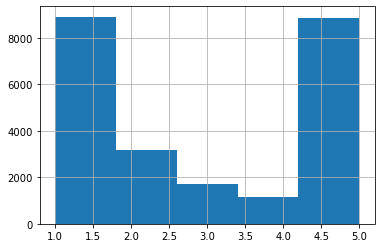

In [5]:
max_examples = 5

target_words_df = clean_seq_reviews_df['target_word'].value_counts().to_frame()
balanced_df = clean_seq_reviews_df.groupby('output', group_keys=False).progress_apply(lambda group: group.sample(n=min(len(group.index), max_examples)))
_ = balanced_df['output'].value_counts().hist(bins=5)

In [6]:
max_seq_len = balanced_df['seq_len'].max()
balanced_df['seq'] = balanced_df['seq'].progress_apply(lambda seq: [0] * (max_seq_len - len(seq)) + seq)

100%|██████████| 69350/69350 [00:00<00:00, 384644.86it/s]


In [7]:
balanced_df.head()

,text,target_word,output,seq,wc,seq_len
645929,<start> texture crackers taste good baby mum m...,<end>,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",11,11
396904,<start> first tried unforgetable tea visiting ...,<end>,2,"[1, 92, 1740, 309040, 3903, 3086, 1092, 92, 50...",41,41
342165,<start> good taste tea bags two four times ful...,<end>,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 142, 3377, 3903...",32,32
1111844,<start> become favorite chips much better pack...,<end>,2,"[0, 0, 0, 0, 0, 0, 0, 1, 708, 4556, 5912, 152,...",34,34
238477,<start> heidi bichon allergies doctor told kee...,<end>,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",22,21


### Train model

In [8]:
def get_arrayed_data(df_set):
    setX = np.stack(df_set['seq'].values, axis=0)
    setY = np.stack(df_set['output'].progress_apply(lambda index: em.embeddings_dict[reversed_input_dict[index]]).values, axis=0)        
    return (setX, setY)

trainX, trainY = get_arrayed_data(balanced_df)
print(trainX.shape)
print(trainY.shape)

100%|██████████| 69350/69350 [00:00<00:00, 808448.67it/s]


(69350, 41)
(69350, 290)


#### Neural network

In [73]:
plt.style.use('ggplot')

def plot_history(history, title=''):
    colors = ['r', 'g', 'b', 'k']
    metrics= ['loss', 'mae']
    
    x = range(1, len(history['loss']) + 1)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.ylim(0, 1.1 * max(history['loss']))
    plt.plot(x, history['loss'], 'r') 
    plt.title(f'Loss')
        
    plt.subplot(1, 2, 2)
    plt.ylim(0, 1.1 * max(history['mae']))
    plt.plot(x, history['mae'], 'b') 
    plt.title(f'MAE')

In [11]:
token_count = len(input_dict) + 1
token_count

611147

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding

embedding_matrix = np.zeros((token_count, em.shape[0]))
for word, i in tqdm(input_dict.items()):
    if word in em.embeddings_dict:
        embedding_matrix[i] = em.embeddings_dict[word]
        
embedding_layer = Embedding(token_count, em.shape[0],
                    weights=[embedding_matrix],
                    input_length=max_seq_len,
                    trainable=False)

100%|██████████| 611146/611146 [00:01<00:00, 490870.40it/s]


In [78]:
def simple_nn_model(show_summary=True):
    inp = tf.keras.layers.Input((max_seq_len,))
    hidden = embedding_layer(inp)
    hidden = tf.keras.layers.BatchNormalization()(hidden)

    hidden = tf.keras.layers.LSTM(2, return_sequences=True)(hidden)
    hidden = BatchNormalization()(hidden)
    
    hidden = tf.keras.layers.LSTM(2)(hidden)
    hidden = BatchNormalization()(hidden)
    
    hidden = tf.keras.layers.Dense(16, activation='relu')(hidden)
    hidden = BatchNormalization()(hidden)

    out = tf.keras.layers.Dense(trainY.shape[1])(hidden)
    model = tf.keras.Model(inp, out)

    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    
    if show_summary:
        print(model.summary())
    
    return model

In [79]:
model = simple_nn_model()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 41)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 41, 290)           177232630 
_________________________________________________________________
batch_normalization_32 (Batc (None, 41, 290)           1160      
_________________________________________________________________
lstm_20 (LSTM)               (None, 41, 2)             2344      
_________________________________________________________________
batch_normalization_33 (Batc (None, 41, 2)             8         
_________________________________________________________________
lstm_21 (LSTM)               (None, 2)                 40        
_________________________________________________________________
batch_normalization_34 (Batc (None, 2)                 8  

In [80]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

save_best = ModelCheckpoint('models/best_weights.hdf5', save_best_only=True, monitor='loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='loss', mode='min', factor=0.2, patience=5, verbose=1, cooldown=2)

history = model.fit(
    trainX, trainY,
    batch_size=64,
    callbacks=[save_best, reduce_lr],
    epochs=25
)

Train on 69350 samples
Epoch 1/25
69350/69350 [==============================] - 18s 257us/sample - loss: 0.0109 - mae: 0.0746
Epoch 2/25
69350/69350 [==============================] - 14s 204us/sample - loss: 0.0089 - mae: 0.0697
Epoch 3/25
69350/69350 [==============================] - 14s 209us/sample - loss: 0.0089 - mae: 0.0697
Epoch 4/25
69350/69350 [==============================] - 14s 208us/sample - loss: 0.0089 - mae: 0.0696
Epoch 5/25
69350/69350 [==============================] - 14s 204us/sample - loss: 0.0089 - mae: 0.0696
Epoch 6/25
69350/69350 [==============================] - 14s 206us/sample - loss: 0.0088 - mae: 0.0695
Epoch 7/25
69184/69350 [============================>.] - ETA: 0s - loss: 0.0088 - mae: 0.0695
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
69350/69350 [==============================] - 14s 207us/sample - loss: 0.0088 - mae: 0.0695
Epoch 8/25
69350/69350 [==============================] - 14s 206us/sample - loss: 0

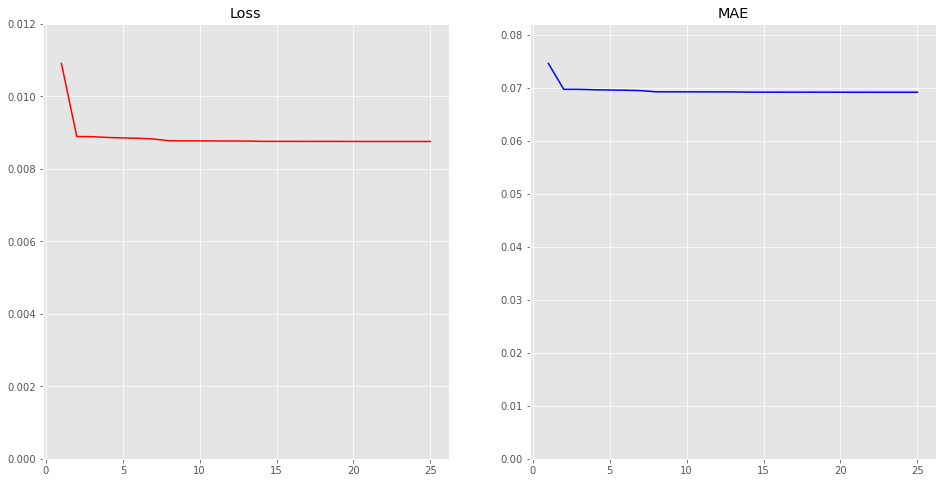

In [81]:
plot_history(history.history)

#### Producing result

In [82]:
def generate_sequence(initial_sentence, max_generated_length=max_seq_len):
    sentence = f'{start_token} {initial_sentence.lower()}'
    inapropriate_tokens = [start_token, pad_token]
    
    for i in tqdm(range(max_generated_length)):
        sequence = [input_dict[word] for word in sentence.split() if word in input_dict]
        if len(sequence) >= max_seq_len:
            return sentence

        padded_sequence = [0] * (max_seq_len - len(sequence)) + sequence

        array = np.array(padded_sequence)
        input_array = array.reshape((-1, array.shape[0]))
        result = model.predict(input_array).reshape(em.shape)
        
        word_scores = em.get_words(result, k=3)
        for word_score in word_scores:
            word = word_score[0]
            if word not in inapropriate_tokens:
                new_word = word
                break
                
        sentence += ' ' + new_word

        if new_word == end_token:
            print('End token received.')
            return sentence

In [83]:
generate_sequence('I have bought')

 90%|█████████ | 37/41 [00:13<00:01,  2.72it/s]


'<start> i have bought tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut'

In [84]:
generate_sequence('really this was an amazing stuff for me to find')

 73%|███████▎  | 30/41 [00:10<00:03,  2.87it/s]


'<start> really this was an amazing stuff for me to find tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut'

In [85]:
generate_sequence('')

 98%|█████████▊| 40/41 [00:13<00:00,  3.01it/s]


'<start>  tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut tehut'